------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis/blob/main/code.ipynb)__ 
------------------------------------------------------------------------------------------------------------------------

In [70]:
#this line imports the functions needed for this project
%run code.ipynb

# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [71]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [72]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (simple_common_stations(simple_common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['05792', '05705', '00867', '00691', '02014', '02290', '03730', '00701', '01975', '05100', '02261', '05371', '04887', '02597', '04104', '03032', '03631', '01691', '04371', '01550', '01639', '02601', '00656', '05906']


### Let's plot the stations to make sure that the points are representative for whole Germany:

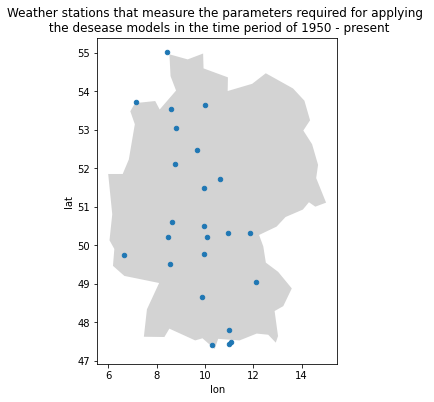

In [73]:
plot_points_germany(1950)


#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

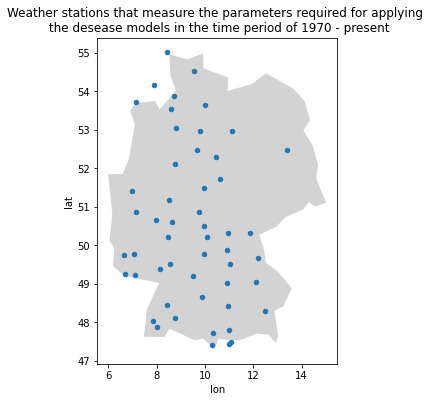

In [74]:
plot_points_germany(1970)


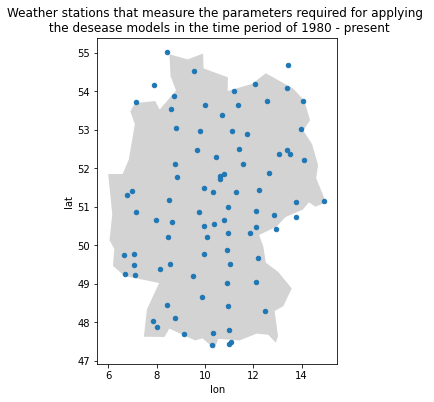

In [75]:
plot_points_germany(1980)

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

## Step 2. Downloading the data